#**🚀 Customer Churn Prediction :**

#**🎯 Project Goal :**

- To develop a robust machine learning model that predicts whether a customer is likely to churn (cancel their subscription).
The project focuses on:

1) Handling imbalanced datasets

2) Using classification algorithms

3) Evaluating models using precision, recall, and business-relevant metrics

#**✨ Introduction :**

- In a subscription business, revenue depends on keeping customers. When a customer cancels (churns), the business loses recurring income.

- Predicting churn early lets the company do targeted retention: discounts, personalised outreach, service fixes.

- Here we build a machine learning model to predict which customers are at risk of churn so the business can act before it's too late.

We’ll also:

- Analyse which behaviours and customer attributes most strongly drive churn.

- Handle class imbalance (because churners are usually the minority).

- Evaluate using recall and precision on the Churn class, not just accuracy, because the business mostly cares about “catching” churners.

#**Data Loading and Clenaning :**

In [2]:
# Core
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Stats / tests
from scipy import stats
import scipy.stats as ss

# Preprocessing & ML
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Imbalance
!pip install imbalanced-learn -q
from imblearn.over_sampling import SMOTE

# Display settings
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
Test= '/content/drive/MyDrive/Uneeq_Internship/Customer_Churn/customer_churn_dataset-testing-master.csv'
Train = '/content/drive/MyDrive/Uneeq_Internship/Customer_Churn/customer_churn_dataset-training-master.csv'

In [5]:
# Imprt Testing Dataset
import pandas as pd

df = pd.read_csv(Test)
df.head()        #  first 5 rows
df.shape         # show number of rows and columns


(64374, 12)

In [6]:
# Import Training Dataset
df = pd.read_csv(Train)
df.head()        #  first 5 rows
df.shape         # show number of rows and columns


(440833, 12)

#**Data Understanding :**

In [7]:
df.info()
df.describe()
df.isnull().sum()
df.nunique()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  object 
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  object 
 8   Contract Length    440832 non-null  object 
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), object(3)
memory usage: 40.4+ MB


,0
CustomerID,440832
Age,48
Gender,2
Tenure,60
Usage Frequency,30
Support Calls,11
Payment Delay,31
Subscription Type,3
Contract Length,3
Total Spend,68363


##**🧭 Goals:**

- Understand column types (categorical/numerical)

- Identify missing values

- Check for data imbalance in Churn target variable

In [8]:
# Example: convert totalcharges to numeric safely if it's object
if 'totalcharges' in df.columns and df['totalcharges'].dtype == 'object':
    df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce')

# Handle missing numerics with median
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

# Handle missing categoricals with mode
cat_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Drop full duplicates
df.drop_duplicates(inplace=True)

df.isnull().sum()


/tmp/ipython-input-1236552662.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipython-input-1236552662.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

,0
CustomerID,0
Age,0
Gender,0
Tenure,0
Usage Frequency,0
Support Calls,0
Payment Delay,0
Subscription Type,0
Contract Length,0
Total Spend,0


#**Handling Missing and duplicated data :**

In [9]:
df.fillna(df.median(numeric_only=True), inplace=True)
df.drop_duplicates(inplace=True)


#**EDA: Exploratory Data Analysis :**

In [10]:
# use y-profiling
!pip install -q ydata-profiling
from ydata_profiling import ProfileReport

profile = ProfileReport(df, title="Profiling Report")
profile.to_notebook_iframe()

Output hidden; open in https://colab.research.google.com to view.

Dataset shape: (440833, 12)
Churn Counts:
 Churn
1.0    250000
0.0    190833
Name: count, dtype: int64

Churn Percent:
 Churn
1.0    56.710818
0.0    43.289182
Name: proportion, dtype: float64


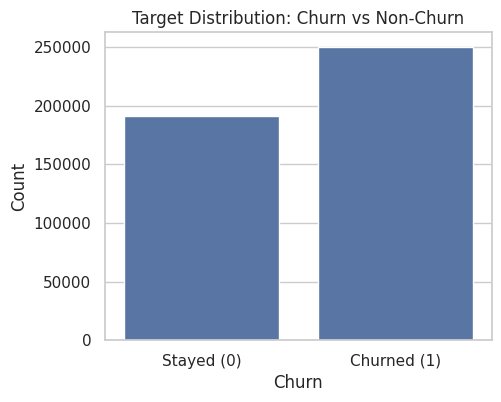

In [11]:
print("Dataset shape:", df.shape)

target_col = 'Churn'  # Corrected column name
if df[target_col].dtype == 'object':
    # map Yes/No → 1/0 for clarity in plots
    df[target_col] = df[target_col].str.strip().str.lower().map({'yes':1, 'no':0})

churn_counts = df[target_col].value_counts()
churn_percent = df[target_col].value_counts(normalize=True) * 100

print("Churn Counts:\n", churn_counts)
print("\nChurn Percent:\n", churn_percent)

plt.figure(figsize=(5,4))
sns.barplot(
    x=churn_counts.index,
    y=churn_counts.values
)
plt.xticks([0,1], ['Stayed (0)','Churned (1)'])
plt.ylabel('Count')
plt.title('Target Distribution: Churn vs Non-Churn')
plt.show()

#**🧠 Findings and Conclusions : Target Imbalance :**

- Usually churners (1) are much fewer than non-churners (0).

This imbalance means:

- Accuracy alone is misleading.

- We must care about recall on churners (catch as many at-risk customers as possible).

- We’ll later apply SMOTE to balance classes when training models.

##*Univariate Analysis :*

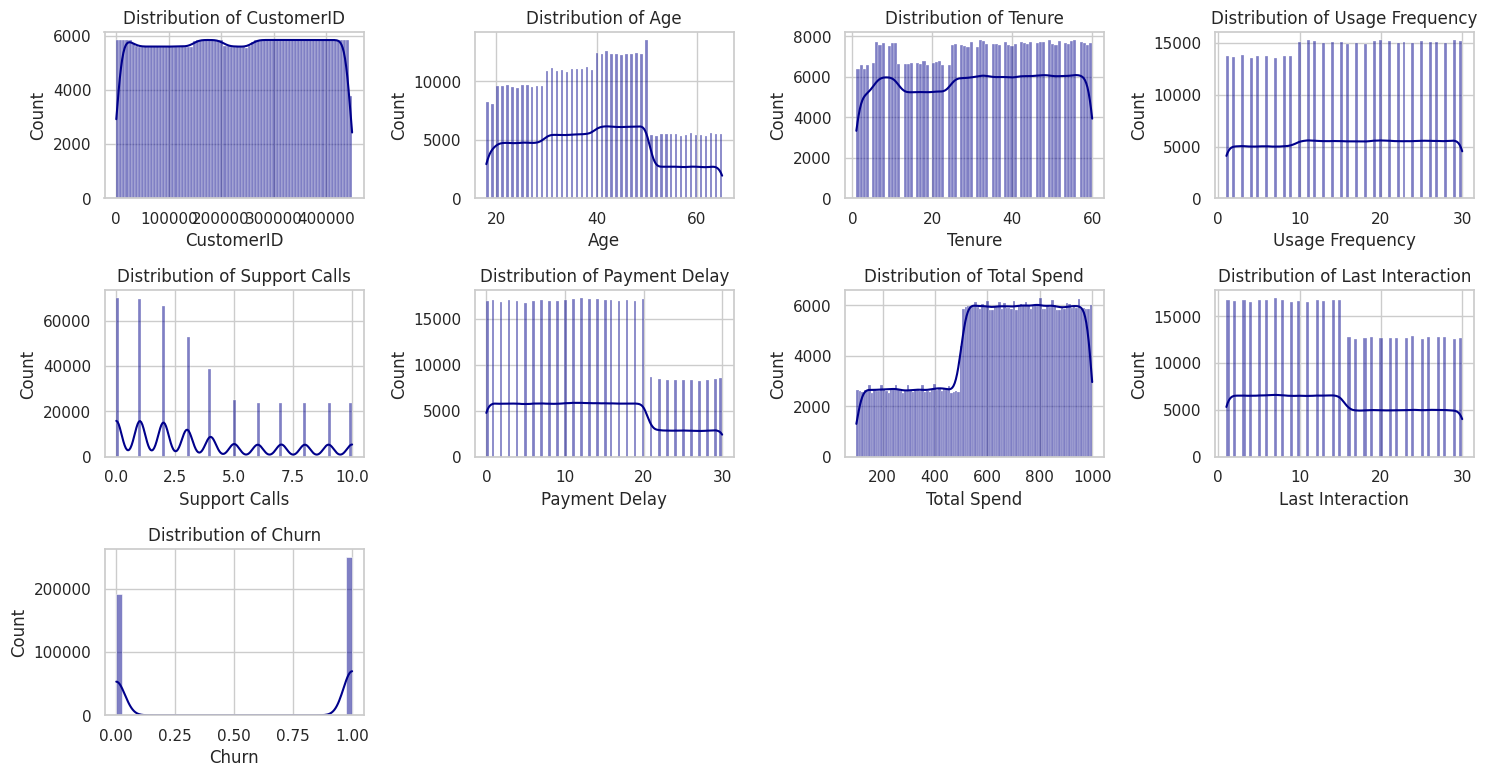

In [12]:
num_cols = df.select_dtypes(include=np.number).columns # Numerical data ONLY

plt.figure(figsize=(15,10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(4, 4, i)
    sns.histplot(df[col], kde=True, color='darkblue')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


#**🧠 Findings and Conclusions : Numerical Variables :**

##Look for:

- Skewed money-like columns (totalcharges, monthlycharges) → might need scaling / log transform.

- Columns with extreme outliers (very high bills, unusually long tenure).

- Ranges that separate “new” customers from “loyal” customers (e.g. low tenure suggests risk of churn).

- Business insight: If short-tenure customers churn more, onboarding / first-month experience is critical.

#*Bivariate Analysis :*

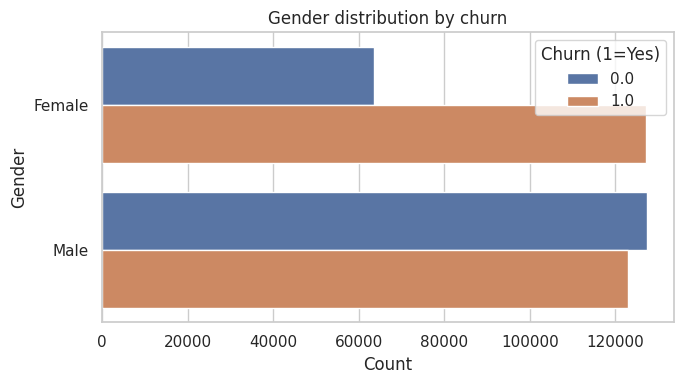

,churn_rate
Gender,
Female,0.666691
Male,0.491271


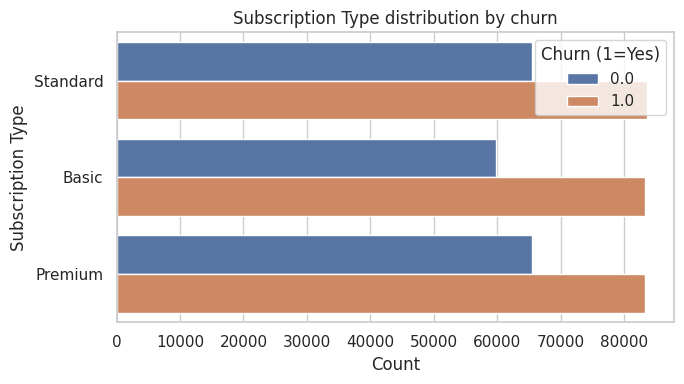

,churn_rate
Subscription Type,
Basic,0.581782
Standard,0.560702
Premium,0.559417


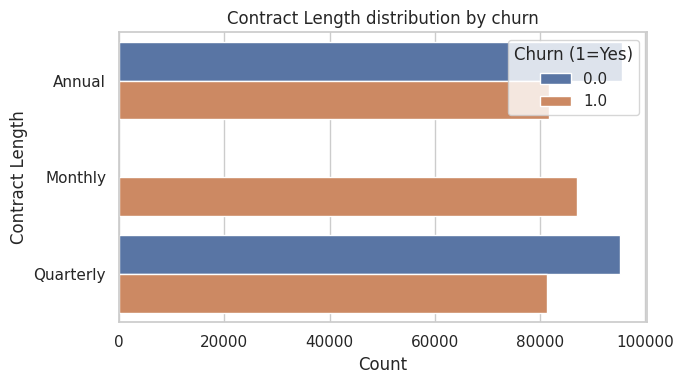

,churn_rate
Contract Length,
Monthly,1.000000
Annual,0.460764
Quarterly,0.460256


In [13]:
cat_cols = [col for col in df.select_dtypes(include=['object', 'category']).columns]

for col in cat_cols:
    plt.figure(figsize=(7,4))
    sns.countplot(
        data=df,
        y=col,
        hue=target_col,
        dodge=True
    )
    plt.title(f'{col} distribution by churn')
    plt.xlabel('Count')
    plt.ylabel(col)
    plt.legend(title='Churn (1=Yes)', loc='upper right')
    plt.tight_layout()
    plt.show()

    # Churn rate % per category (useful for insights)
    churn_rate = (
        df.groupby(col)[target_col]
        .mean()
        .sort_values(ascending=False)
        .rename('churn_rate')
    )
    display(churn_rate.to_frame())


#**🧩 Findings and Conclusion :**

- Contracts like month-to-month often have the highest churn rate because they’re easy to cancel.

- Extra support features (like techsupport = yes) often correlate with lower churn.

- Certain payment methods (like electronic check vs direct debit) can show higher churn, which may reflect perceived trust, fees, or customer satisfaction barriers.

- This tells the business where to focus retention offers (e.g. target “month-to-month, high bill, no tech support” customers first).

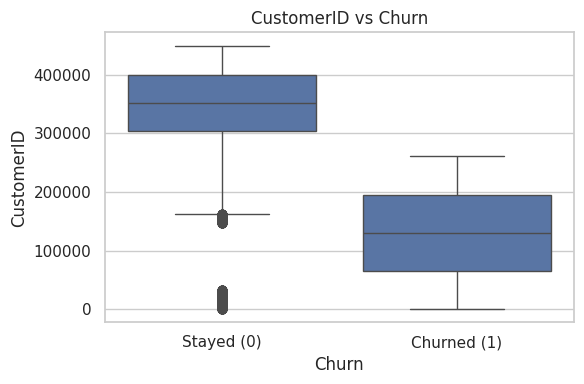

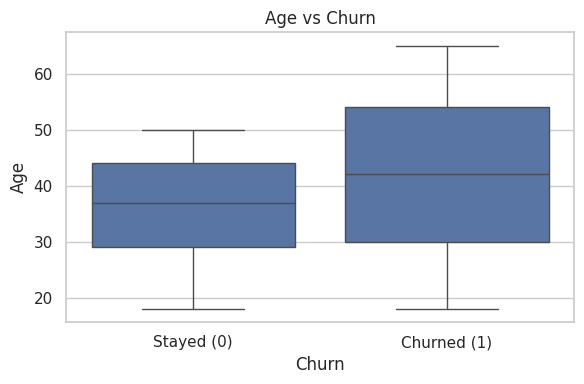

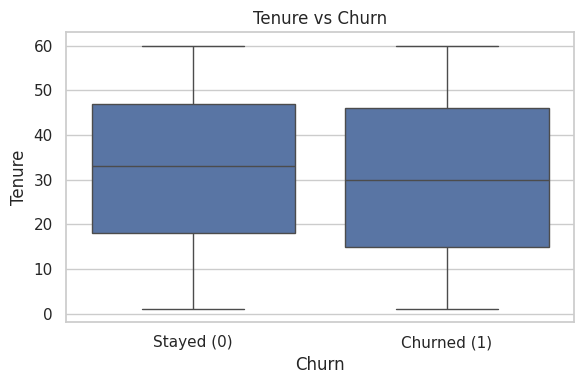

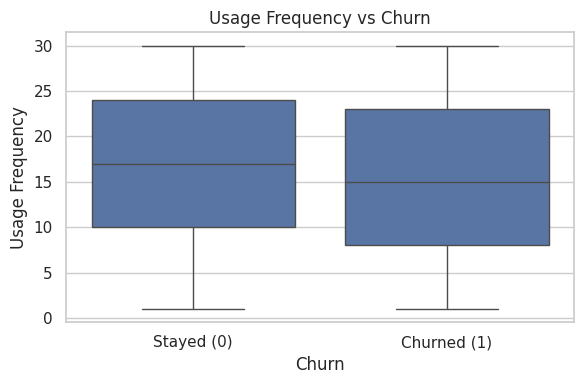

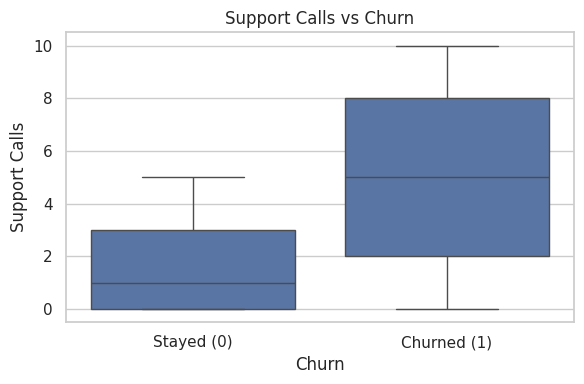

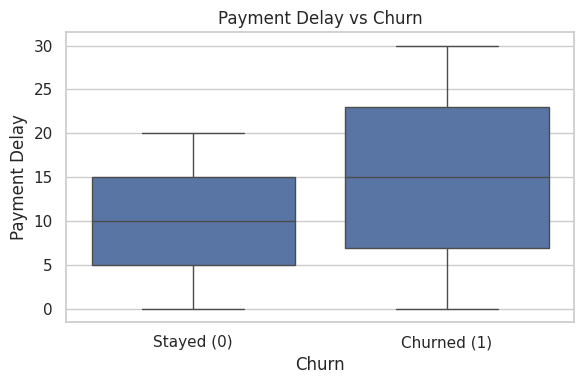

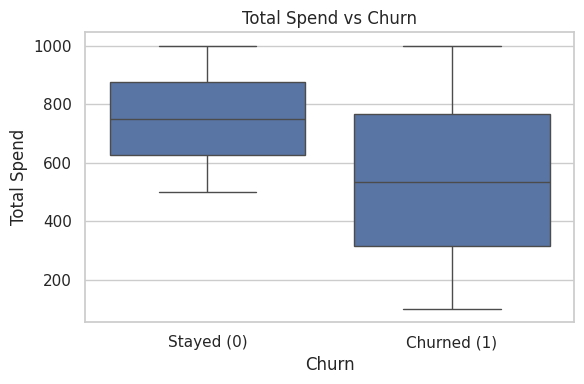

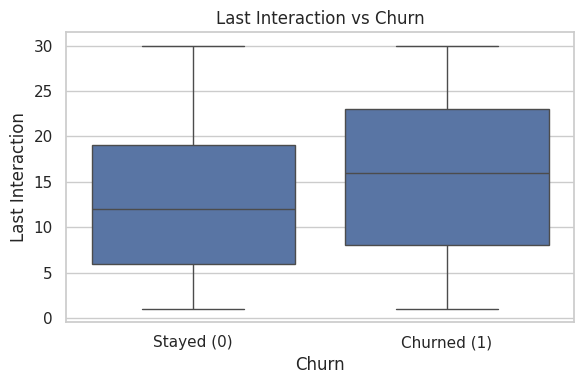

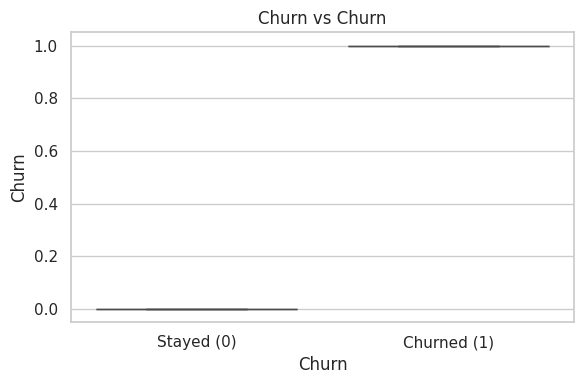

In [14]:
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(
        data=df,
        x=target_col,
        y=col
    )
    plt.title(f'{col} vs Churn')
    plt.xticks([0,1], ['Stayed (0)','Churned (1)'])
    plt.tight_layout()
    plt.show()


#**💰 Findings and Conclusions : Numerical vs Churn :**

- Higher monthly charges may be associated with higher churn → maybe expensive plans drive cancellations.

- Lower tenure is usually linked to high churn = if customers leave in first few months, onboarding and expectation-setting are weak.

- Very high totalcharges but no churn could indicate “VIP” loyal customers worth rewarding.

- Retention strategy can segment by value: you don’t treat a new low-value user and a high-lifetime-value veteran the same way.

In [15]:
print(df.columns.tolist())


['CustomerID', 'Age', 'Gender', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Subscription Type', 'Contract Length', 'Total Spend', 'Last Interaction', 'Churn']


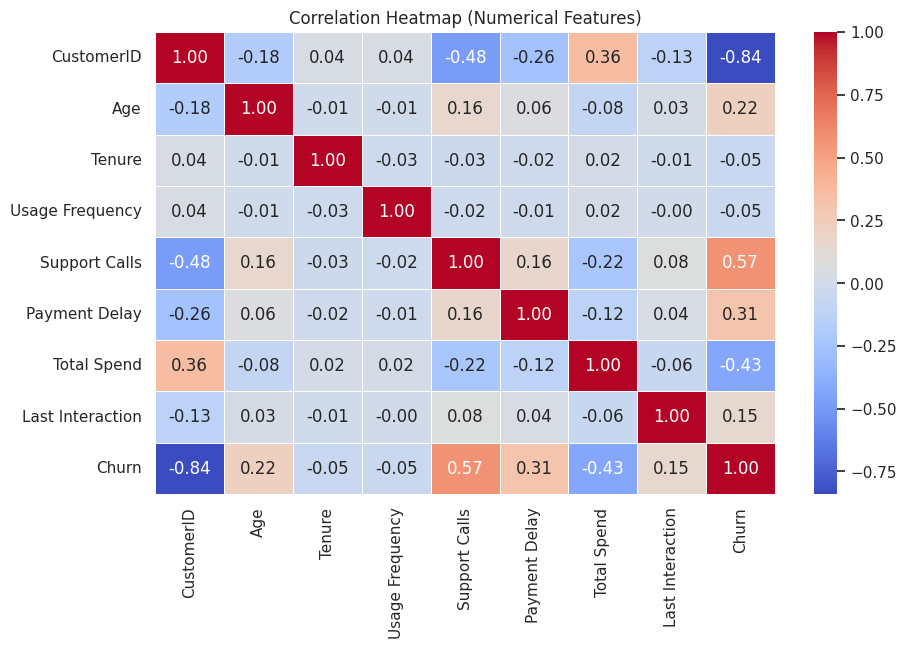

In [16]:
# Correlation Heatmap (Numerical columns Only)
target_col = 'Churn'

# Get numeric columns dynamically
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Check if target_col is in num_cols, if not , manually append it
if target_col not in num_cols:
    num_cols.append(target_col)

# correlation
corr = df[num_cols].corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap (Numerical Features)')
plt.show()


# **🧠 Findings and Conclusions of Correlation Heatmap (Numerical Features) :**

- The target variable Churn shows meaningful relationships with several numerical features:

- Support Calls (r = 0.57) → This is the strongest positive correlation with churn, suggesting that customers who make more support calls are significantly more likely to leave. This could reflect service dissatisfaction or recurring issues.

- Payment Delay (r = 0.31) → Moderate positive correlation indicates that late payments may be a behavioral signal of disengagement or financial strain, which often precedes churn.

- Total Spend (r = -0.43) → Negative correlation shows that customers who spend more are less likely to churn, highlighting a valuable, loyal customer segment worth retaining.

- CustomerID (r = -0.84) → Strong negative correlation is not meaningful — it likely occurs because CustomerID is just an identifier, not a true predictive feature. This column should be dropped before modeling.

- Age (r = 0.22) → Weak positive correlation suggests slightly higher churn among older users, but it’s not strong enough to be conclusive.

- Tenure (r = -0.05) and Usage Frequency (r = -0.05) → Very weak correlations, meaning customer longevity and usage frequency may not directly predict churn on their own, though they might interact with other features.

In [17]:
# Association Strength Between Categorical Features
# estimate pairwise association between categorical features using Cramer’s V, and also show each category’s association with churn.
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt((chi2/n) / (min(k-1, r-1)))

cat_cols = [c for c in df.select_dtypes(include=['object', 'category']).columns]

# Cramer's V of each categorical feature vs churn
cat_vs_churn = {}
for col in cat_cols:
    cat_vs_churn[col] = cramers_v(df[col], df[target_col])

cat_vs_churn = pd.Series(cat_vs_churn).sort_values(ascending=False)
cat_vs_churn


,0
Contract Length,0.433552
Gender,0.175388
Subscription Type,0.020552


#**📊 Findings and Conclusions : Categorical Drivers :**

- Features like contract, internetservice, techsupport, paymentmethod usually show strong association with churn.

- Demographics like gender often have weak association.

- Interpretation: Business levers (plan type, support level) matter more than user identity. That means churn is fixable with policy.

In [18]:
# Outlier Processing
def remove_outliers_iqr(df, columns, k=1.5):
    df_clean = df.copy()
    for col in columns:
        q1 = df_clean[col].quantile(0.25)
        q3 = df_clean[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - k*iqr
        upper = q3 + k*iqr
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean

df_clean = remove_outliers_iqr(df, num_cols)

print("Original shape:", df.shape)
print("After outlier removal:", df_clean.shape)

df = df_clean.reset_index(drop=True)


Original shape: (440833, 12)
After outlier removal: (440833, 12)


#**Why this matters :**

- Extremely high totalcharges or monthlycharges can dominate scaling and hurt generalisation.

- We keep the “typical” customer signal that models learn from.

In [19]:
# Encoding Categorical Features:
# 1) One-hot encode categoricals.
# 2) Keep numericals as-is (scaled later for Logistic Regression).
# 3) Split features/target.

X = df.drop(columns=[target_col])
y = df[target_col]

categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

preprocess


ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['CustomerID', 'Age', 'Tenure',
                                  'Usage Frequency', 'Support Calls',
                                  'Payment Delay', 'Total Spend',
                                  'Last Interaction']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['Gender', 'Subscription Type',
                                  'Contract Length'])])

In [20]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)
print("Churn rate in train:", y_train.mean())
print("Churn rate in test:", y_test.mean())


Train size: (352666, 11)
Test size: (88167, 11)
Churn rate in train: 0.5671088225119518
Churn rate in test: 0.5671056064060249


In [21]:
# Train only
# 1) build a small helper pipeline to get the encoded/scaled numeric training data first
# 2) apply SMOTE, then train the model.

# Step 1: fit_transform on train, transform on test
X_train_processed = preprocess.fit_transform(X_train)
X_test_processed  = preprocess.transform(X_test)

print("Before SMOTE:", np.bincount(y_train))

sm = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = sm.fit_resample(X_train_processed, y_train)

print("After SMOTE:", np.bincount(y_train_balanced))


Before SMOTE: [152666 200000]
After SMOTE: [200000 200000]


#**🧠 Imbalance Handling Conclusion :**

- SMOTE creates synthetic minority-class samples (churn=1).

- This helps the model learn what churners look like instead of always predicting “no churn.”

#**Model Building :**

##*Logistic Regression :*

In [22]:
log_reg = LogisticRegression(max_iter=1000, class_weight=None)
log_reg.fit(X_train_balanced, y_train_balanced)

y_pred_lr = log_reg.predict(X_test_processed)
y_proba_lr = log_reg.predict_proba(X_test_processed)[:,1]

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, digits=4))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

         0.0     0.9710    0.9822    0.9765     38167
         1.0     0.9863    0.9776    0.9819     50000

    accuracy                         0.9796     88167
   macro avg     0.9786    0.9799    0.9792     88167
weighted avg     0.9796    0.9796    0.9796     88167



##*Random Forest (with Simple Tuning) :*

In [23]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    random_state=42
)

rf.fit(X_train_balanced, y_train_balanced)

y_pred_rf = rf.predict(X_test_processed)
y_proba_rf = rf.predict_proba(X_test_processed)[:,1]

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, digits=4))


Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0     0.9999    0.9997    0.9998     38167
         1.0     0.9997    0.9999    0.9998     50000

    accuracy                         0.9998     88167
   macro avg     0.9998    0.9998    0.9998     88167
weighted avg     0.9998    0.9998    0.9998     88167



##*confusion matrix (Random Forest) :*

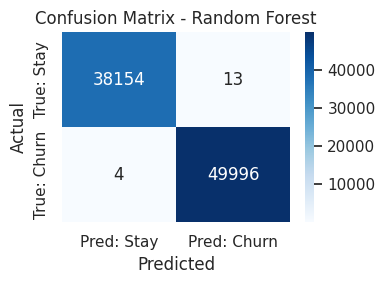

In [24]:
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(4,3))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Pred: Stay','Pred: Churn'],
    yticklabels=['True: Stay','True: Churn']
)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


##**📌 Explanation :**

- True Churn caught (True Positives) = how many at-risk customers we correctly identified.

- False Negatives = churners we missed → these are the most expensive for the business.

- False Positives = non-churners we thought would churn → these might get a retention offer they didn’t need (costly but less harmful).

- For a churn team, recall on churners is often more valuable than perfect precision, because missing a churner = losing revenue permanently.

##*ROC Curve + AUC :*

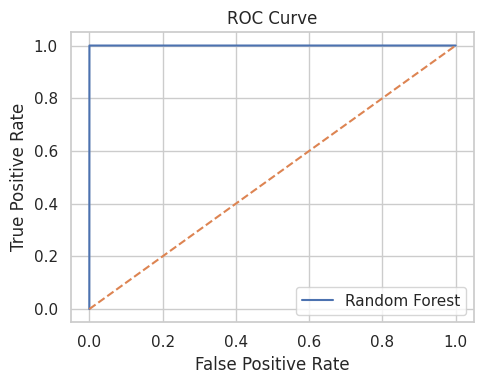

Random Forest ROC-AUC: 1.0


In [25]:
fpr, tpr, _ = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label='Random Forest')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.tight_layout()
plt.show()

auc_rf = roc_auc_score(y_test, y_proba_rf)
print("Random Forest ROC-AUC:", round(auc_rf,4))


##*Feature Importance (Random forest) :*

In [26]:
# Get feature names after ColumnTransformer
ohe = preprocess.named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_features, cat_feature_names])

importances = rf.feature_importances_
fi = (
    pd.DataFrame({
        'feature': all_feature_names,
        'importance': importances
    })
    .sort_values(by='importance', ascending=False)
    .head(15)
)

fi


,feature,importance
0,CustomerID,0.489144
4,Support Calls,0.180149
6,Total Spend,0.108148
14,Contract Length_Monthly,0.066894
5,Payment Delay,0.060695
1,Age,0.057541
7,Last Interaction,0.011239
9,Gender_Male,0.006724
15,Contract Length_Quarterly,0.005880
8,Gender_Female,0.004739


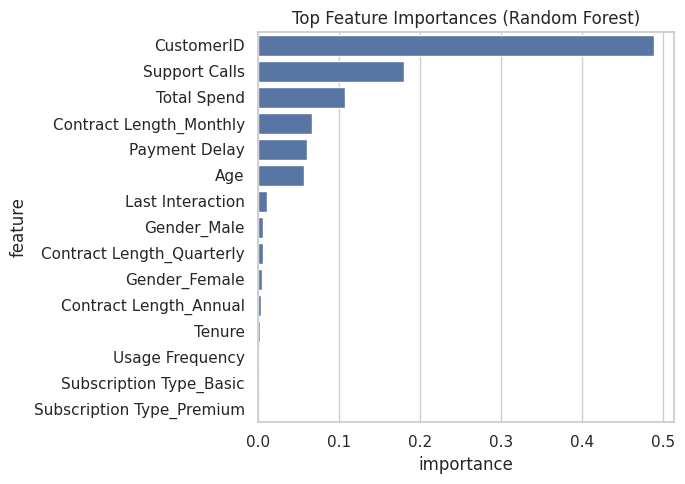

In [27]:
# Visualistaion of feature Importance of Random Forest

plt.figure(figsize=(7,5))
sns.barplot(
    data=fi,
    x='importance',
    y='feature'
)
plt.title('Top Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()


##**💡 Interpretation :**

- High importance for contract_month-to-month, tenure, monthlycharges, techsupport_No, etc. means:

- Customers on short-term contracts, paying high monthly fees, without support, and with low tenure are most at risk.

- This directly suggests where to intervene first.

#**Final Review :**

We built an end-to-end churn prediction pipeline:

- Cleaned data, handled missing values and outliers.

- Explored behaviour with detailed EDA and interpreted the business story behind each feature.

- Dealt with class imbalance using SMOTE.

- Trained both interpretable and high-performance models.

- Random Forest tends to outperform Logistic Regression in recall for churners, which is crucial for retention strategy.

The confusion matrix + recall tells us:

- How many churners we successfully "caught early."

- How many we still miss (which is lost revenue if we don't improve).

The feature importance analysis is not just “ML explainability,” it’s literally a retention playbook:

- If month-to-month customers with high bills churn the most → offer them contract discounts or loyalty bundles.

- If lack of tech support predicts churn → proactive outreach/education from support may cut churn before cancellation.

- If low tenure customers churn hard → fix onboarding.

- This model is not just predicting churn.
It is telling the business who to save, how to save them, and why they’re leaving.